# Dataset 1: analysis

In [1]:
import numpy as np
import scipy
from scipy import signal as sig
from matplotlib import pyplot as plt
import os

%matplotlib inline

In [2]:
PATH = "../data/dataset/2"

In [3]:
all_files = [file for file in os.listdir(PATH) if file.endswith(".nfc")]
all_files.sort()

In [4]:
# RF constants
SAMP_RATE = 912000
CENTER_FREQ = int(13.56e6)
NFFT = 1024

In [5]:
# Read all signals with their filename
signals = []

for file in all_files:
    signal = np.fromfile(os.path.join(PATH, file), dtype=scipy.complex64)
    name = file[:-4]
    signals.append((name, signal))

## Signal characteristics

In [6]:
stats = []

for signal in signals:
    mags = np.abs(signal[1][100000:200000])
    stats.append(scipy.stats.describe(mags))

In [7]:
print("Number of points", len(signals[0][1]))
for idx, stat in enumerate(stats):
    print("Signal", idx + 1, "---------------------------------------------------")
    print("Min and max:", stat.minmax, "mean:", stat.mean)
    print("Variance:", stat.variance, "skewness:", stat.skewness)
    print("------------------------------------------------------------")

Number of points 18240000
Signal 1 ---------------------------------------------------
Min and max: (6.198173e-06, 0.0012077804) mean: 0.00027317987
Variance: 4.5446626e-08 skewness: 1.2830455303192139
------------------------------------------------------------
Signal 2 ---------------------------------------------------
Min and max: (2.1931971e-06, 0.0035271775) mean: 0.00026370693
Variance: 4.4983892e-08 skewness: 1.6852515935897827
------------------------------------------------------------
Signal 3 ---------------------------------------------------
Min and max: (1.8022678e-06, 0.15544933) mean: 0.00032300258
Variance: 5.489179e-06 skewness: 54.29233932495117
------------------------------------------------------------
Signal 4 ---------------------------------------------------
Min and max: (7.490467e-06, 0.0012358653) mean: 0.0002559732
Variance: 4.083537e-08 skewness: 1.343314290046692
------------------------------------------------------------
Signal 5 ----------------------

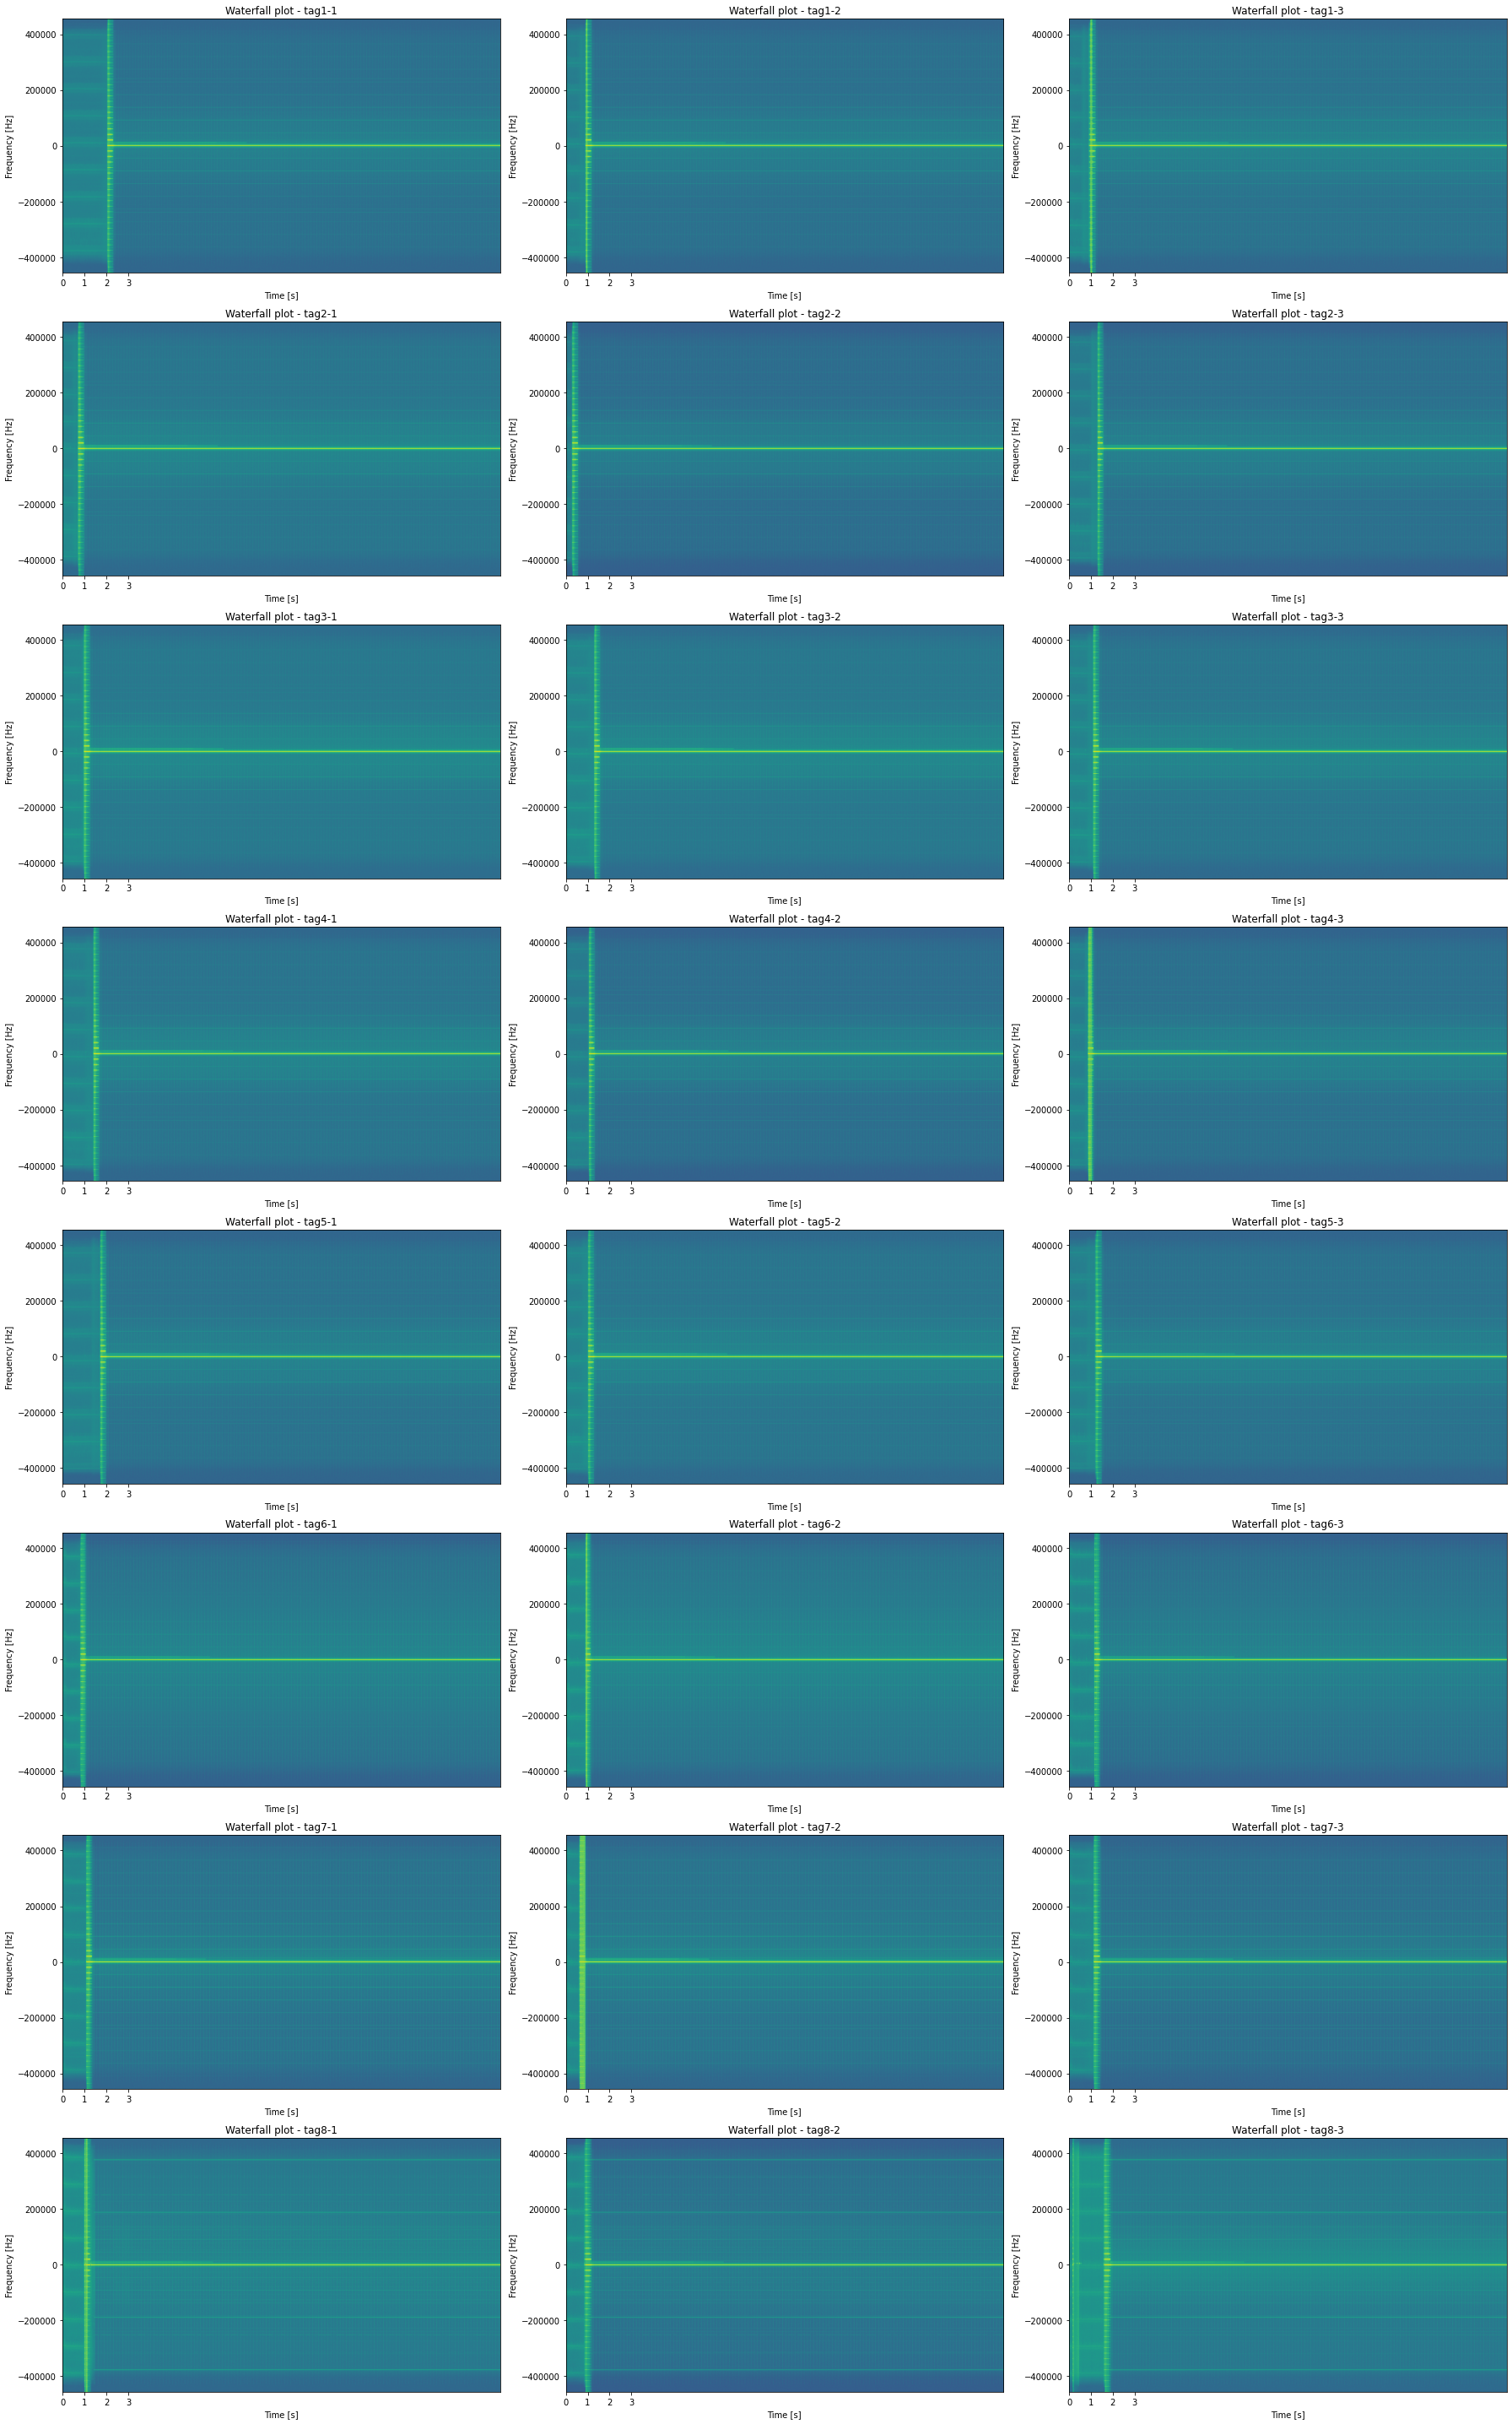

In [8]:
fig, axs = plt.subplots(len(signals) // 3, 3, figsize=(25, 40))

for signal, ax in (t for t in zip(signals, axs.flat)):
    ax.specgram(signal[1], NFFT=NFFT, Fs=SAMP_RATE)
    ax.set_title("Waterfall plot - {}".format(signal[0]))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xticks(range(0, 4))

plt.tight_layout()
plt.show()

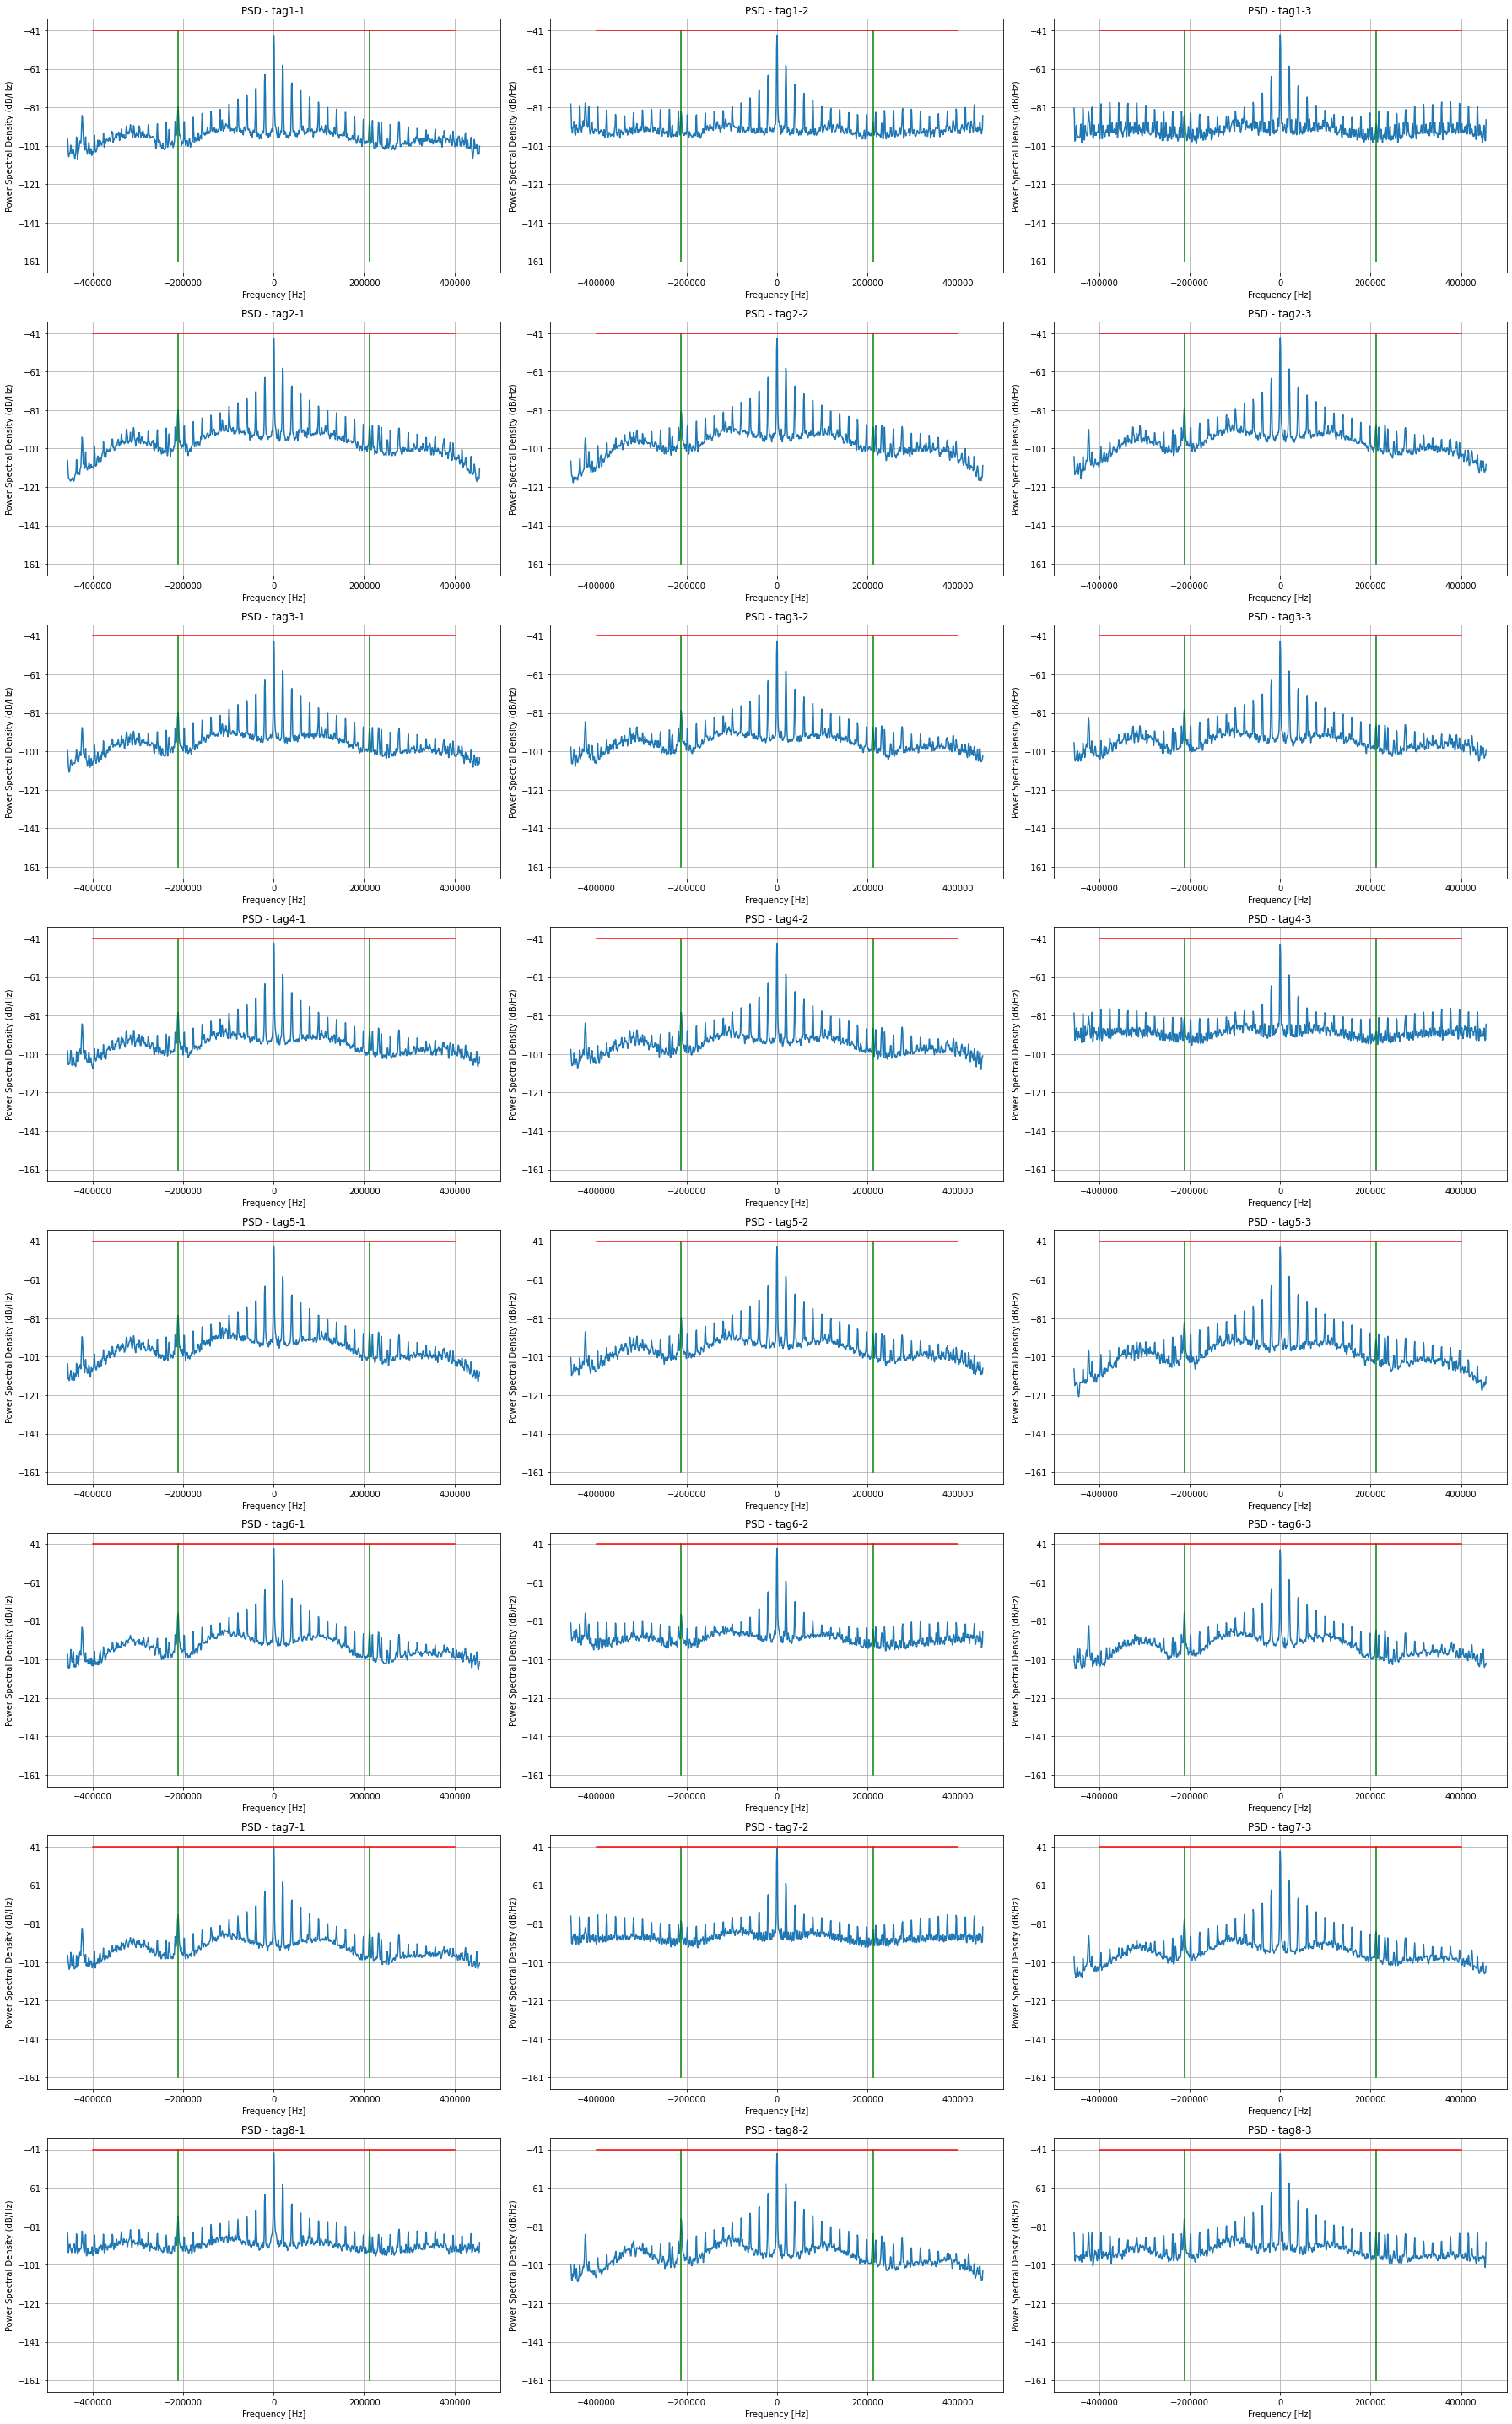

In [9]:
fig, axs = plt.subplots(len(signals) // 3, 3, figsize=(25, 40))

for signal, ax in (t for t in zip(signals, axs.flat)):
    ax.psd(signal[1], NFFT=NFFT, Fs=SAMP_RATE)
    ax.plot([-212000, -212000], [-161, -41], 'g-')
    ax.plot([212000, 212000], [-161, -41], 'g-')

    ax.plot([-400000, 400000], [-41, -41], 'r-')
    #ax.plot([-400000, 400000], [-101, -101], 'r-')
    
    ax.set_yticks(range(-161, -21, 20))
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("PSD - {}".format(signal[0]))

plt.tight_layout()
plt.show()

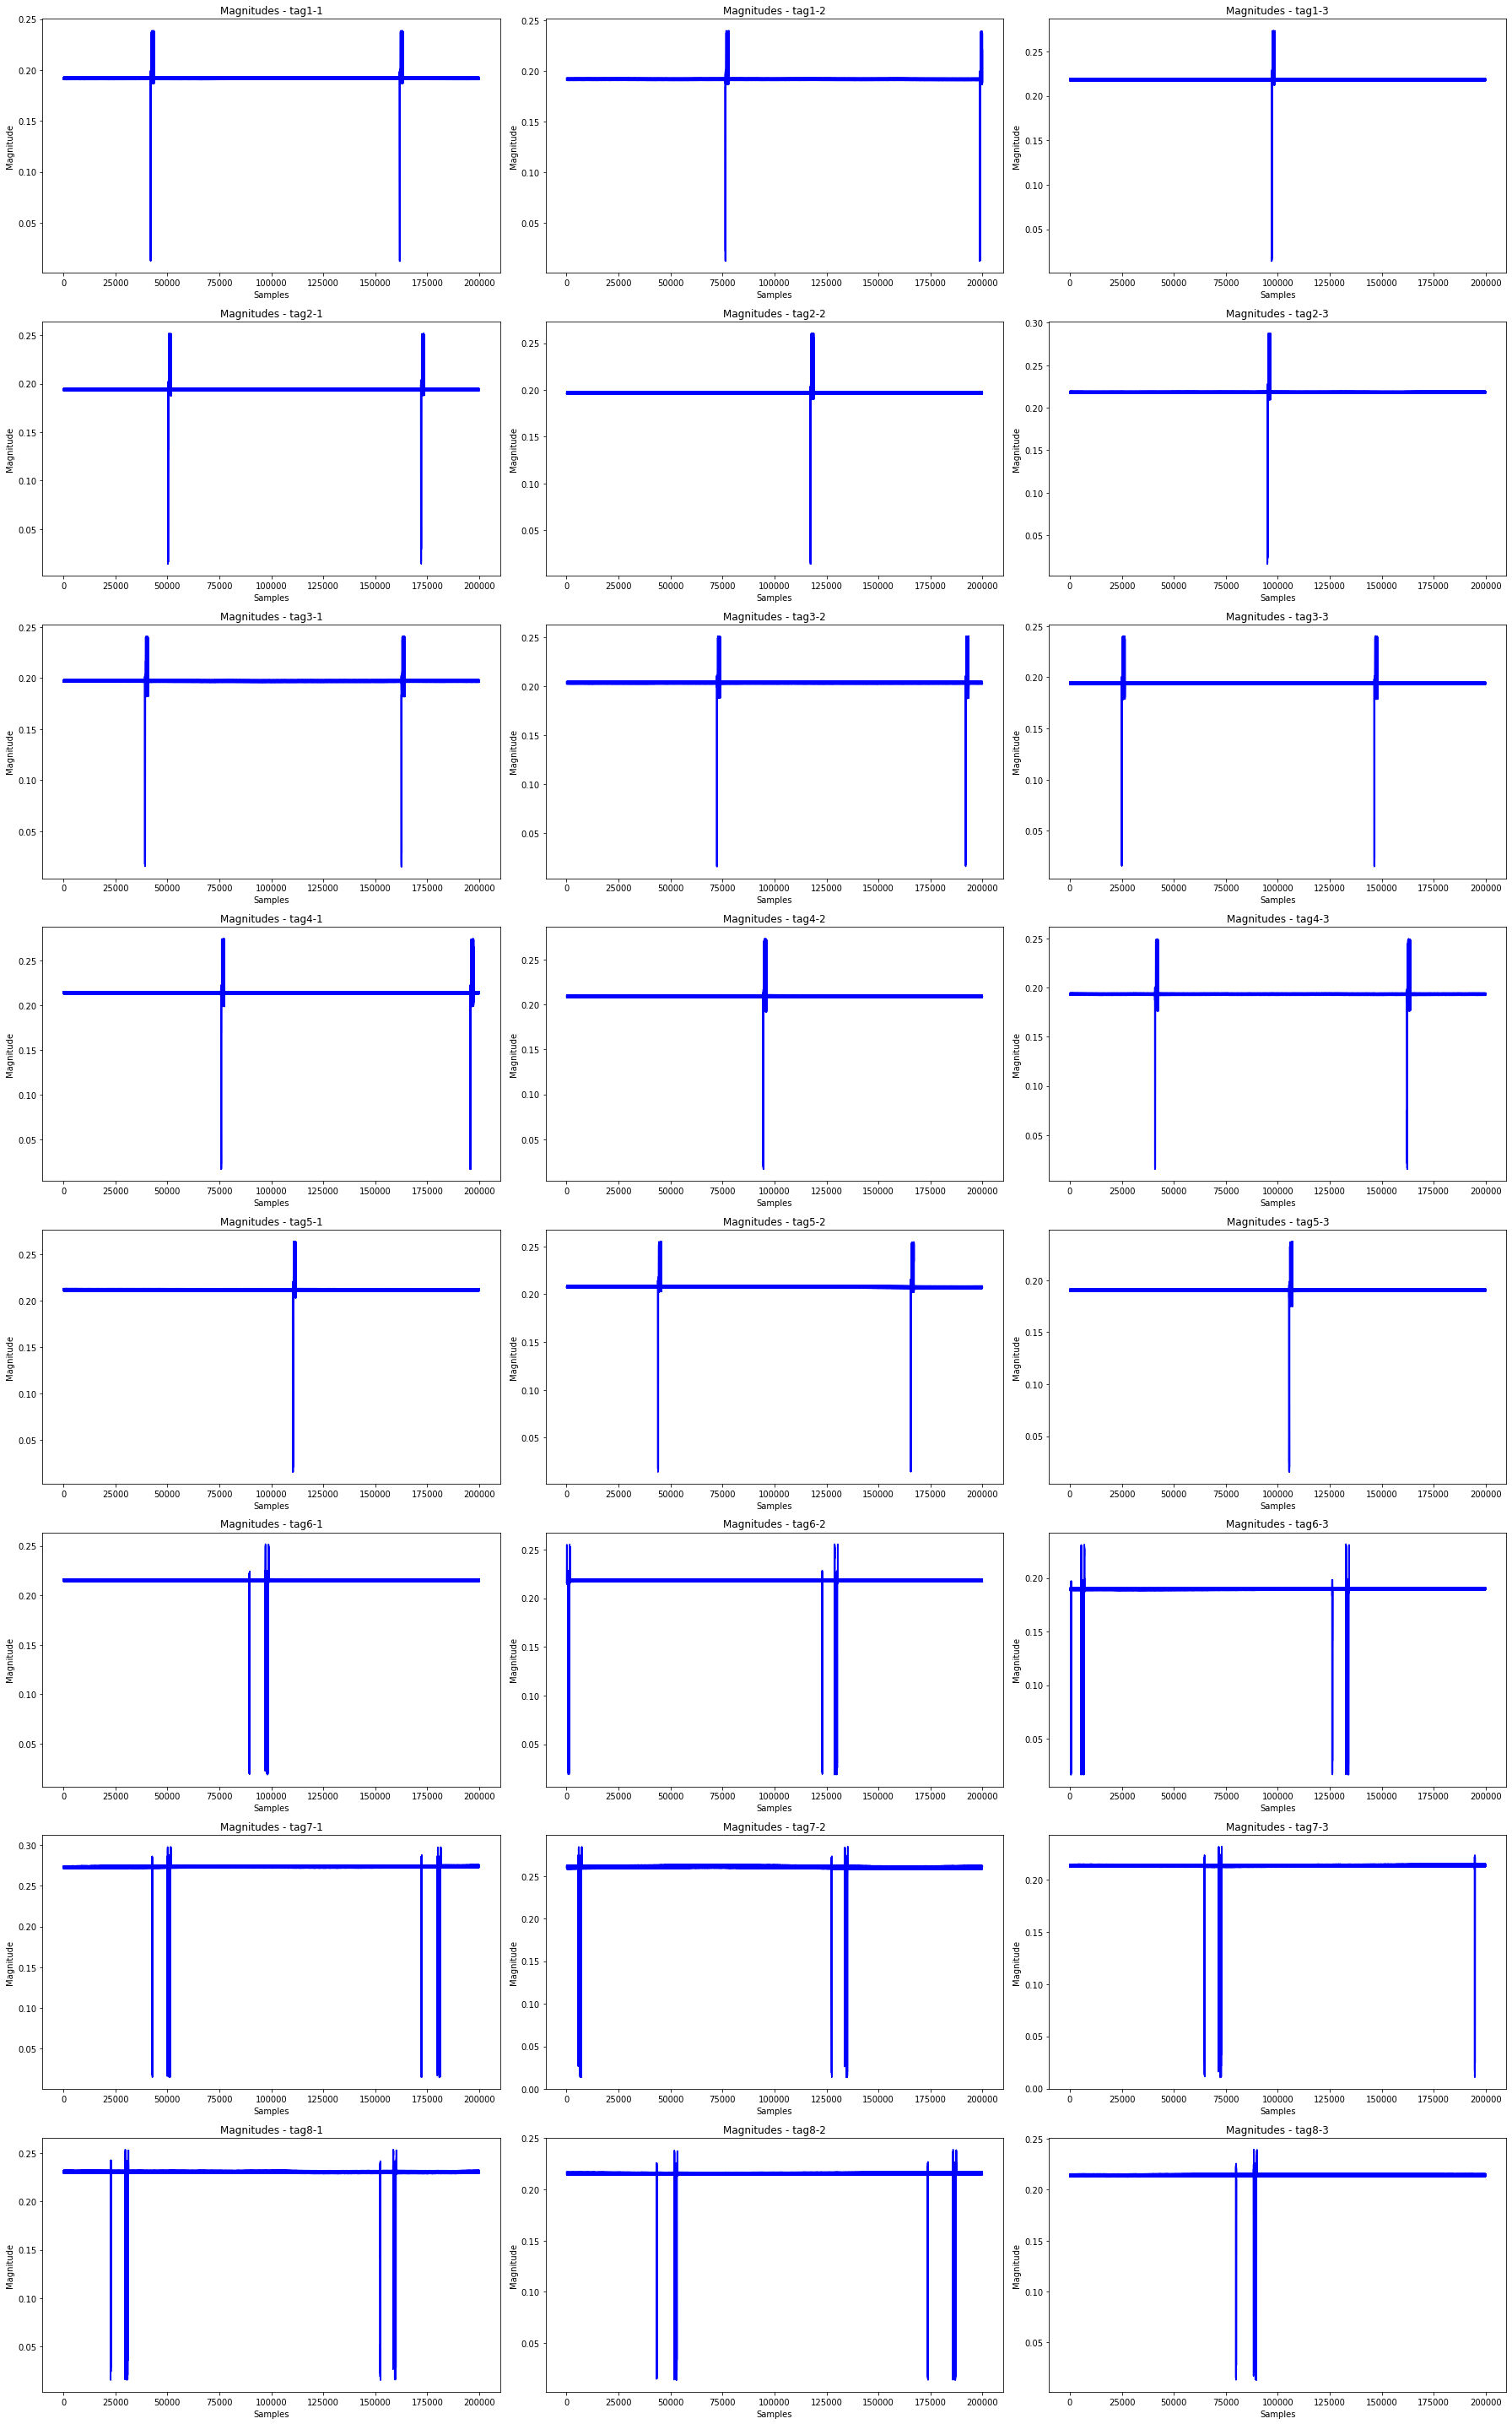

In [10]:
fig, axs = plt.subplots(len(signals) // 3, 3, figsize=(25, 40))

for signal, ax in (t for t in zip(signals, axs.flat)):
    ax.plot(np.abs(signal[1][3000000:3200000]), 'b-')
    ax.set_xlabel("Samples")
    ax.set_ylabel("Magnitude")
    ax.set_title("Magnitudes - {}".format(signal[0]))

plt.tight_layout()
plt.show()

## Peak detection

In [11]:
def normalize_amplitude(signal):
    real = np.real(signal)
    imag = np.imag(signal)
    max_val = abs(max(max(real.max(), imag.max()),
                      min(real.min(), imag.min()),
                      key=abs))

    # Convert the normalized lists to complex
    return (real / max_val) + 1j * (imag / max_val)

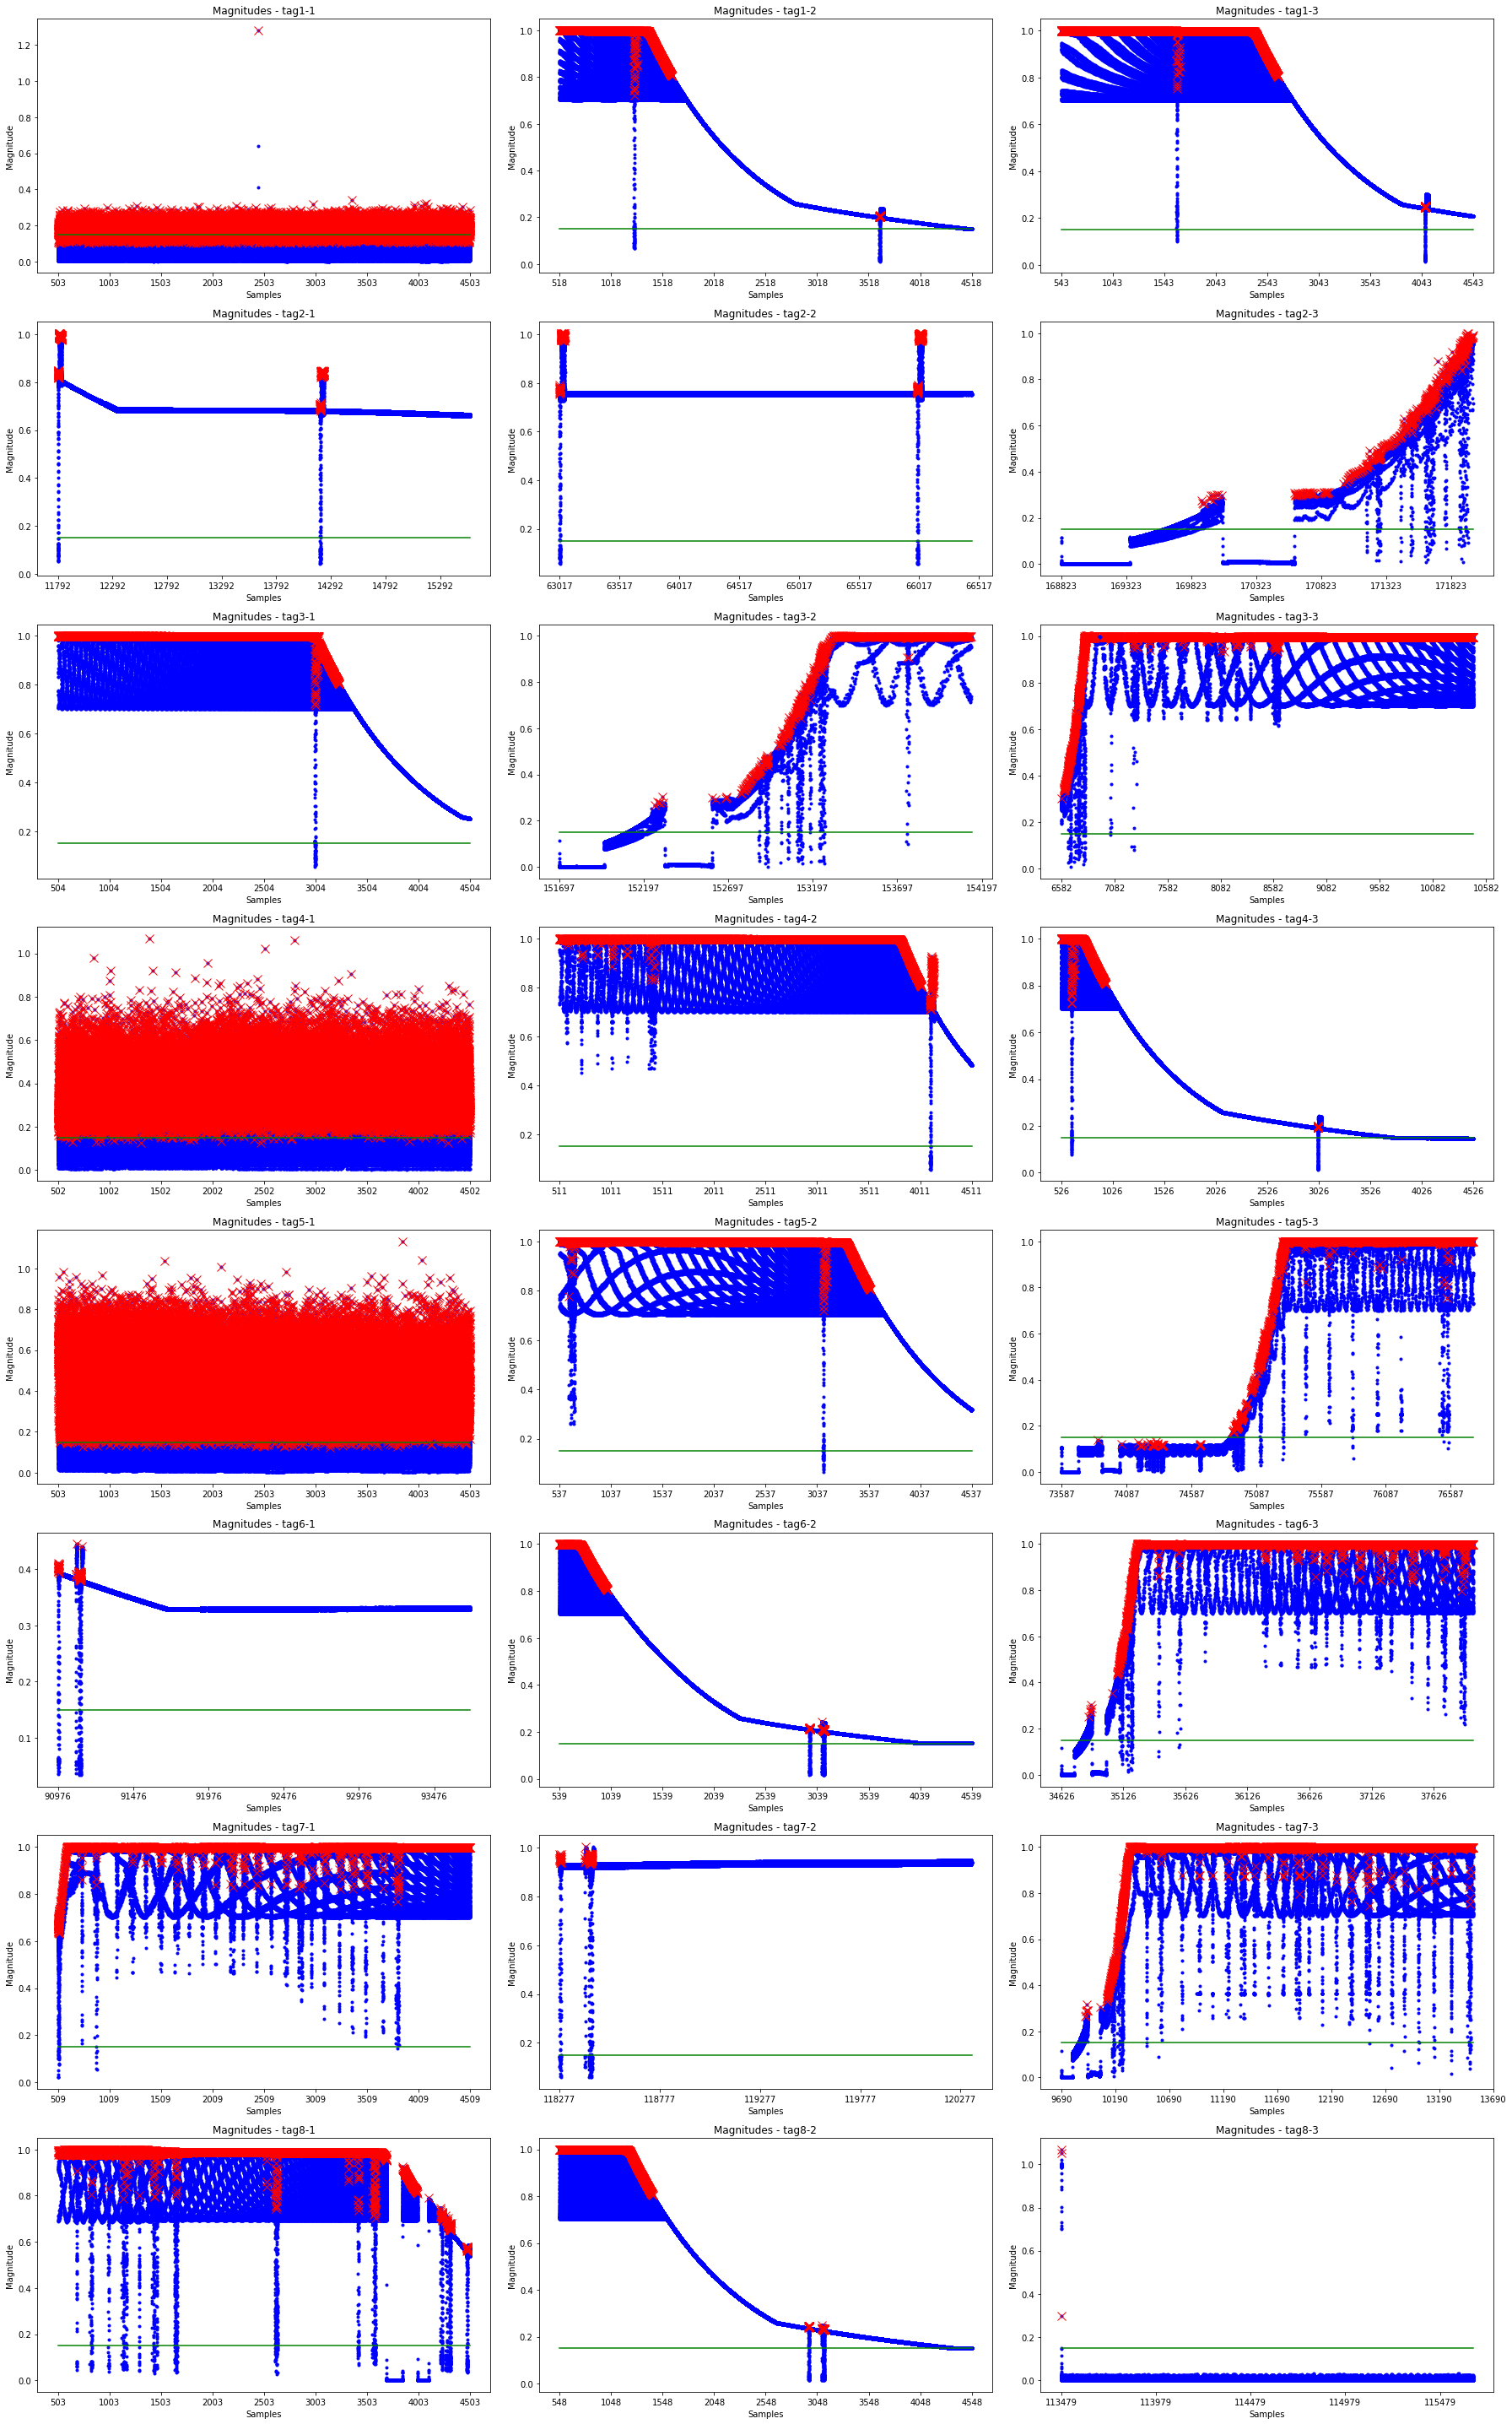

In [12]:
fig, axs = plt.subplots(len(signals) // 3, 3, figsize=(25, 40))

#start, stop = 3000000, 3200000
start, stop = 1000000, 1200000
prominence = 0.1

for signal, ax in (t for t in zip(signals, axs.flat)):
    mags = np.abs(normalize_amplitude(signal[1][start:stop]))
    
    peaks = sig.find_peaks(mags, prominence=prominence)
    fp = peaks[0][0]
    
    mags = mags[fp:fp + start]
    
    peaks = sig.find_peaks(mags, prominence=prominence)
    peaks_rep = [x for i, x in enumerate(mags) if i in peaks[0]]
    
    ax.plot(mags, 'b.')
    ax.plot(peaks[0], peaks_rep, 'rx', markersize=10)
    ax.plot([0, len(mags)], [0.15, 0.15], 'g-')
    
    ax.set_xticklabels(range(fp, fp + 5001, 500))
    ax.set_xlabel("Samples")
    ax.set_ylabel("Magnitude")
    ax.set_title("Magnitudes - {}".format(signal[0]))

plt.tight_layout()
plt.show()

In [41]:
def segments_peaks2(signal, segments_size):
    mags = np.abs(signal)
    indices = np.where(mags < 0.25)[0]
    segments = []

    while indices.size != 0:
        start = indices[0]
        indices = indices[segments_size:]
        segments.append(signal[start:start + segments_size])

    return list(zip(np.real(segments), np.imag(segments)))

In [14]:
def segments_peaks(signal, segments_size, prominence=0.005):
    mags = np.abs(signal)
    indices = sig.find_peaks(mags, prominence=prominence)[0]
    segments = []

    while indices.size != 0:
        start = indices[0]
        indices = indices[segments_size:]
        segments.append(signal[start:start + segments_size])

    return list(zip(np.real(segments), np.imag(segments)))

In [15]:
#for idx, signal in enumerate(signals):
    #print(idx, len(segments_peaks2(signal[1], 256)))

In [45]:
for i in range(4):
    windows = segments_peaks(signals[0][1][:100000], 256)
    plt.plot(windows[i][0], 'b-', windows[i][1], 'r-')
    plt.show()

IndexError: list index out of range